In [38]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.neighbors import KNeighborsClassifier 
import matplotlib.pyplot as plt
import seaborn as sn

In [39]:
# Constants
IMAGE_SIZE = (224, 224)  
NUM_CLASSES = 63  
DATASET_PATH = r"D:\3rd year first semster\MACHINE LEARNING\DATASET"  
chosen_classes = {32, 38, 17, 19, 61}

In [40]:
def load_dataset(path , folder):
    images = []
    labels = []
    IMAGE_SIZE = (224, 224)  # Target size as (width, height)
    path = os.path.join(path, folder)

    for class_label in chosen_classes:
        class_name = f"{class_label:05}"
        class_path = os.path.join(path, class_name)
        if not os.path.exists(class_path):
            continue
        for file in os.listdir(class_path):
            img_path = os.path.join(class_path, file)
            if os.path.splitext(file)[1].lower() != ".ppm":
                continue
            try:
                # Use OpenCV to load and preprocess the image
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
                if img is None:
                    print(f"Skipping invalid image: {img_path}")
                    continue

                img = cv2.resize(img, IMAGE_SIZE)  # Resize to target size (224x224)
                img = img / 255.0  
                images.append(img)
                labels.append(class_label)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
                continue

    return np.array(images), np.array(labels)


In [41]:
# Load training data
X_train, y_train = load_dataset(DATASET_PATH, "Training")
X_val, y_val = load_dataset(DATASET_PATH, "Testing")
y_train = to_categorical(y_train, NUM_CLASSES)
y_val = to_categorical(y_val, NUM_CLASSES)

In [42]:
# Flatten image data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)


In [43]:
# Train Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_flat, np.argmax(y_train, axis=1))

LogisticRegression(max_iter=1000)

In [44]:
# Evaluate Logistic Regression
y_pred_logistic = logistic_model.predict(X_val_flat)
y_pred_prob_logistic = logistic_model.predict_proba(X_val_flat)
print("Logistic Regression Accuracy:", accuracy_score(np.argmax(y_val, axis=1), y_pred_logistic))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(np.argmax(y_val, axis=1), y_pred_logistic))
print("Logistic Regression Classification Report:\n", classification_report(np.argmax(y_val, axis=1), y_pred_logistic))

Logistic Regression Accuracy: 0.994475138121547
Logistic Regression Confusion Matrix:
 [[183   0   0   0   0]
 [  0 163   0   0   0]
 [  2   0 416   0   4]
 [  0   0   0 213   0]
 [  0   0   0   0 105]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

          17       0.99      1.00      0.99       183
          19       1.00      1.00      1.00       163
          32       1.00      0.99      0.99       422
          38       1.00      1.00      1.00       213
          61       0.96      1.00      0.98       105

    accuracy                           0.99      1086
   macro avg       0.99      1.00      0.99      1086
weighted avg       0.99      0.99      0.99      1086



Text(95.72222222222221, 0.5, 'truth')

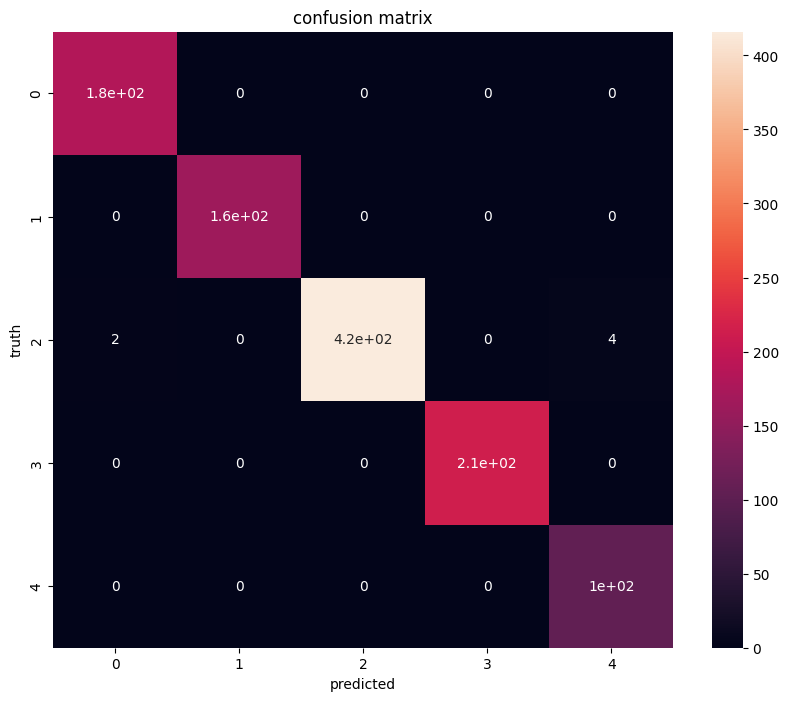

In [50]:
%matplotlib inline
plt.figure(figsize=(10,8))
cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred_logistic)
sn.heatmap(cm , annot=True)
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('truth')

In [45]:
# Train K-Nearest Neighbors Classifier
knn_model = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=2)
knn_model.fit(X_train_flat, np.argmax(y_train, axis=1))

KNeighborsClassifier(n_neighbors=3)

In [46]:
# Evaluate KNN
y_pred_knn = knn_model.predict(X_val_flat)
y_pred_prob_knn = knn_model.predict_proba(X_val_flat)
print("KNN Accuracy:", accuracy_score(np.argmax(y_val, axis=1), y_pred_knn))
print("KNN Confusion Matrix:\n", confusion_matrix(np.argmax(y_val, axis=1), y_pred_knn))
print("KNN Classification Report:\n", classification_report(np.argmax(y_val, axis=1), y_pred_knn))

KNN Accuracy: 0.9511970534069981
KNN Confusion Matrix:
 [[156   1   0   3  23]
 [  0 162   0   0   1]
 [  2  12 399   3   6]
 [  1   0   0 211   1]
 [  0   0   0   0 105]]
KNN Classification Report:
               precision    recall  f1-score   support

          17       0.98      0.85      0.91       183
          19       0.93      0.99      0.96       163
          32       1.00      0.95      0.97       422
          38       0.97      0.99      0.98       213
          61       0.77      1.00      0.87       105

    accuracy                           0.95      1086
   macro avg       0.93      0.96      0.94      1086
weighted avg       0.96      0.95      0.95      1086



Text(95.72222222222221, 0.5, 'truth')

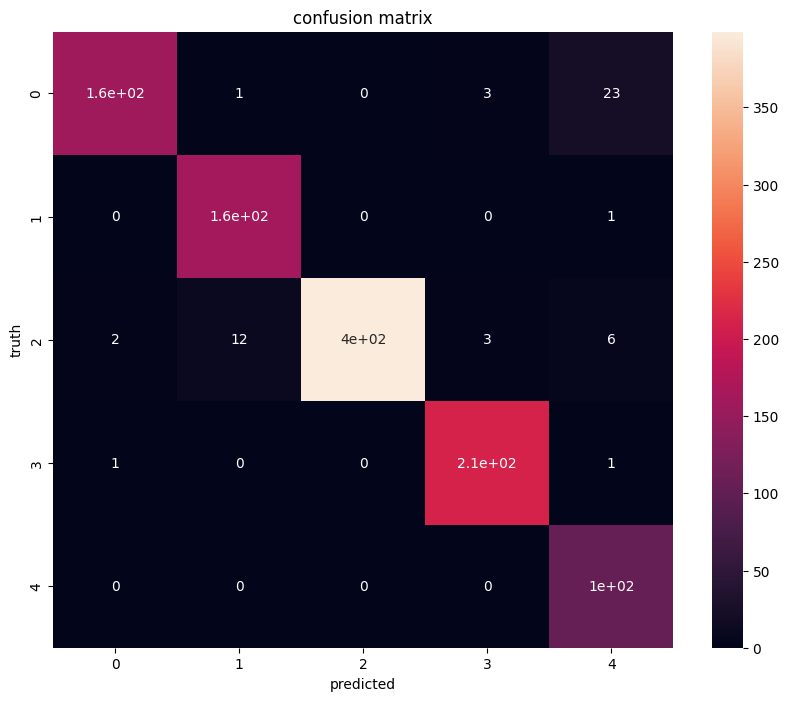

In [47]:
%matplotlib inline
plt.figure(figsize=(10,8))
cm = confusion_matrix(np.argmax(y_val, axis=1), y_pred_knn)
sn.heatmap(cm , annot=True)
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('truth')

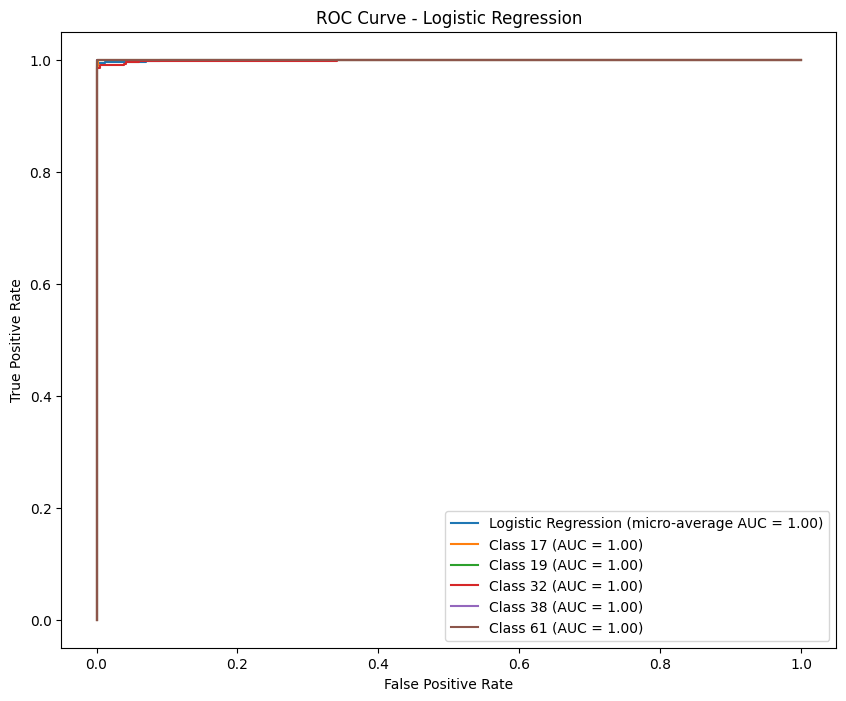

In [48]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_val_indices = np.argmax(y_val, axis=1)

# Dynamically detect unique classes
unique_classes = np.unique(y_val_indices)

# Binarize the labels for ROC computation
y_val_bin = label_binarize(y_val_indices, classes=unique_classes)

# Logistic Regression ROC and AUC
logistic_probs = logistic_model.predict_proba(X_val_flat)

# Compute ROC curve and AUC for each class
fpr_log, tpr_log, roc_auc_log = {}, {}, {}
for i, cls in enumerate(unique_classes):
    fpr_log[cls], tpr_log[cls], _ = roc_curve(y_val_bin[:, i], logistic_probs[:, i])
    roc_auc_log[cls] = auc(fpr_log[cls], tpr_log[cls])

# Compute the micro-average ROC curve and AUC
fpr_log["micro"], tpr_log["micro"], _ = roc_curve(y_val_bin.ravel(), logistic_probs.ravel())
roc_auc_log["micro"] = auc(fpr_log["micro"], tpr_log["micro"])

# Plot ROC curves for Logistic Regression
plt.figure(figsize=(10, 8))
plt.plot(fpr_log["micro"], tpr_log["micro"], label=f'Logistic Regression (micro-average AUC = {roc_auc_log["micro"]:.2f})')
for cls in unique_classes:
    plt.plot(fpr_log[cls], tpr_log[cls], label=f'Class {cls} (AUC = {roc_auc_log[cls]:.2f})')
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

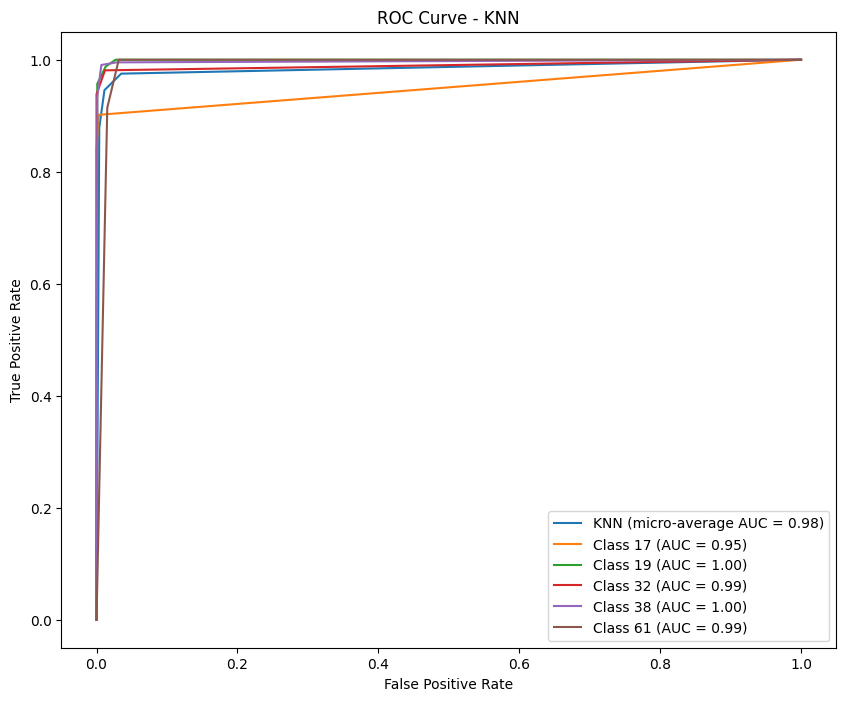

In [49]:
# KNN ROC and AUC
knn_probs = knn_model.predict_proba(X_val_flat)

# Compute ROC curve and AUC for each class
fpr_knn, tpr_knn, roc_auc_knn = {}, {}, {}
for i, cls in enumerate(unique_classes):
    fpr_knn[cls], tpr_knn[cls], _ = roc_curve(y_val_bin[:, i], knn_probs[:, i])
    roc_auc_knn[cls] = auc(fpr_knn[cls], tpr_knn[cls])

# Compute the micro-average ROC curve and AUC
fpr_knn["micro"], tpr_knn["micro"], _ = roc_curve(y_val_bin.ravel(), knn_probs.ravel())
roc_auc_knn["micro"] = auc(fpr_knn["micro"], tpr_knn["micro"])

# Plot ROC curves for KNN
plt.figure(figsize=(10, 8))
plt.plot(fpr_knn["micro"], tpr_knn["micro"], label=f'KNN (micro-average AUC = {roc_auc_knn["micro"]:.2f})')
for cls in unique_classes:
    plt.plot(fpr_knn[cls], tpr_knn[cls], label=f'Class {cls} (AUC = {roc_auc_knn[cls]:.2f})')
plt.title('ROC Curve - KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()
